<a href="https://colab.research.google.com/github/mostafa-ja/Anomaly-detection/blob/main/BGL_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget 'https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/log2index'

--2023-09-12 14:50:31--  https://raw.githubusercontent.com/mostafa-ja/Anomaly-detection/main/datasets/BGL/log2index
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73231 (72K) [application/octet-stream]
Saving to: ‘log2index’

log2index           100%[===================>]  71.51K  --.-KB/s    in 0.009s  

2023-09-12 14:50:31 (8.11 MB/s) - ‘log2index’ saved [73231/73231]



In [2]:
import gensim
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [19]:
with open('/content/log2index') as f:
  templates = [line.strip() for line in f.readlines()]

In [20]:
templates[0]

'ras kernel info instruction cache parity error corrected'

In [ ]:
with open('/content/log2index') as f:
  logs = []
  for line in f.readlines() :
      logs.append([token for token in line.strip().split(' ')])

In [7]:
logs[0]

['ras',
 'kernel',
 'info',
 'instruction',
 'cache',
 'parity',
 'error',
 'corrected']

In [99]:
# Model parameters
word2vec_model =gensim.models.Word2Vec(vector_size=100 ,window=10,  min_count=1, workers=4, sg=1)

# Train the model
word2vec_model.build_vocab(logs, progress_per=10)
word2vec_model.train(logs, total_examples=word2vec_model.corpus_count, epochs=100)

# Save the trained model
word2vec_model.save("./responses.model")

In [100]:
word2vec_model.wv.most_similar("fatal", topn=10)

[('toward', 0.6032884120941162),
 ('normalized', 0.5994853973388672),
 ('denormalized', 0.568600594997406),
 ('ddrsize', 0.5476015210151672),
 ('fffffffe', 0.5093819499015808),
 ('ras', 0.488395094871521),
 ('bglscratchbwallenswlsyscallstestcaseskernelsyscallstimes',
  0.4564340114593506),
 ('buffer', 0.4541797339916229),
 ('scancom', 0.44958242774009705),
 ('bglscratchbwallenswlsyscallstestcaseskernelsyscallsreadlink',
  0.44233590364456177)]

In [102]:
word2vec_model.wv['error']

array([-0.7345399 ,  0.44483864, -0.1741467 ,  0.27559596, -0.02999197,
       -0.30845442,  0.33880836,  0.4347101 , -0.80361605, -0.5505343 ,
        0.38095802,  0.07466942, -0.0092113 , -0.19485343,  0.5037482 ,
       -0.6660405 ,  0.26550275, -0.02489206, -0.22432959, -0.43959096,
       -0.2314804 , -0.19858304,  0.99427885,  0.6451217 , -0.5803976 ,
        0.32181862,  0.09002908,  0.58709407, -0.19750215, -0.1428757 ,
       -0.3205653 , -0.43869838, -0.16236788,  0.27149242,  0.07037525,
        0.02696938,  0.39606148, -0.63911253, -0.44015673, -0.13882393,
       -0.29518545,  0.12356973,  0.49987972, -0.37818587,  0.07306884,
       -0.2740901 ,  0.08642416, -0.3080891 , -0.791925  , -0.08883114,
       -0.20083489, -0.27673227, -0.4097364 , -0.7283937 ,  0.01827188,
       -0.03090446,  0.27979094,  0.3596075 ,  0.1780177 , -0.0540763 ,
        0.10832558,  0.3548    ,  0.56319815, -0.25433168, -0.2388758 ,
       -0.12209142,  0.13639371,  0.37921622, -0.4907327 , -0.30

In [103]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

embeddings = {}
vectorizer = TfidfVectorizer()
matrix_weight = vectorizer.fit_transform(templates)
dic = vectorizer.vocabulary_

for i, (cleaned_template, template) in enumerate(zip(templates, templates)):
    template2vec = np.zeros(100) #300 = word2vector size
    for word in cleaned_template.split():
        j = dic.get(word)  # If the key is not present, dic.get(word)(or dic.get(word, default_value)) will return None (or any default value you provide), while dic[word] will raise a KeyError if the key is not found.
        if j is not None:
            try:
                word_vector = word2vec_model.wv[word]
                template2vec += matrix_weight[i, j] * word_vector
            except KeyError:
                # Handle the case where the word is not found
                pass

    #Normalize the vector
    template2vec = (template2vec/np.linalg.norm(template2vec))
    embeddings[template] = template2vec



In [104]:
sentence_embeddings = np.array(list(embeddings.values()))
print(sentence_embeddings.shape)

(736, 100)


In [105]:
pca = PCA(n_components=2)
pca.fit(sentence_embeddings)
logs_embeddings_2d = pca.transform(sentence_embeddings)
print('logs_embeddings_2d.shape : ',logs_embeddings_2d.shape)
print('remained variance ration : ', np.sum(pca.explained_variance_ratio_))

logs_embeddings_2d.shape :  (736, 2)
remained variance ration :  0.3499639003166386


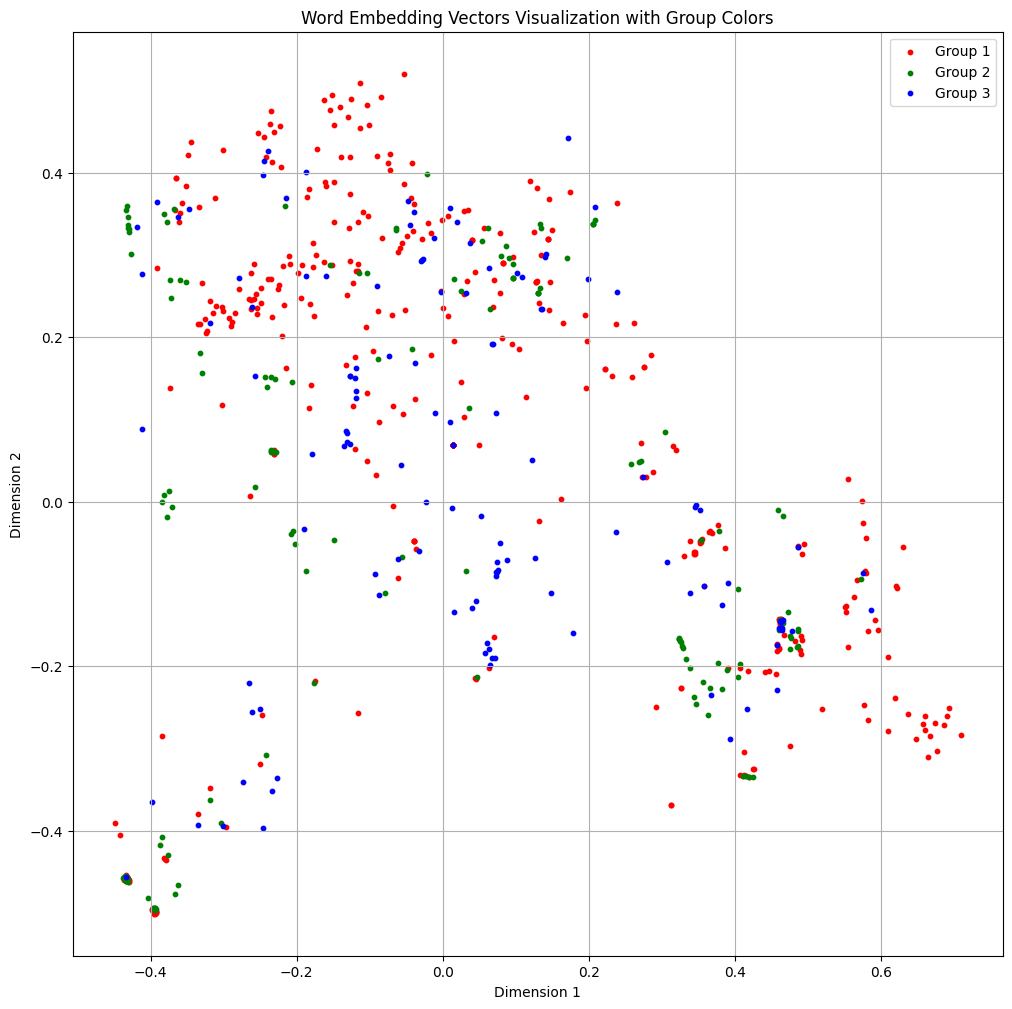

In [108]:
# Define colors for different groups
colors = ['red', 'green', 'blue']
index = [0,437,606,736]


# Create a scatter plot with different colors for each group
plt.figure(figsize=(12, 12))
for i, color in enumerate(colors):
    start_index = index[i]
    end_index = index[(i + 1)]
    plt.scatter(logs_embeddings_2d[start_index:end_index, 0], logs_embeddings_2d[start_index:end_index, 1],
                label=f'Group {i + 1}', c=color, marker='o', s=10)


# Annotate points with words (replace with your own words)
#log_numbers = []
#for i in range(len(logs_embeddings_2d)):
    #word = i # Create a log like "1", "2", ...
    #log_numbers.append(word)

#for i, log_number in enumerate(log_numbers):
    #plt.annotate(log_number, (logs_embeddings_2d[i, 0], logs_embeddings_2d[i, 1]))

# Add labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embedding Vectors Visualization with Group Colors')
plt.legend()

# Show the plot
plt.grid()
plt.show()